Package Imports

In [1]:
#Muhammad Sa'ood Shah 221021204 and Yurvan Ramjan

#General
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import nltk
import keras
#Preprocessing
!pip install wordninja
from bs4 import BeautifulSoup
import wordninja
import matplotlib.pyplot as plt
import seaborn as sns
#Training Models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, LSTM,Embedding
from keras.models import Sequential
from keras.layers import  Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten,BatchNormalization
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers


#Evalation
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=a727ab4fc49a33b2b28ddd05a132021f4c9ca785e3fe4bc4cfcd1cdb784ddb35
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#Load dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Suicide_Detection.csv', encoding="utf-8")
print(data.columns)
data.head()

Mounted at /content/drive
Index(['Unnamed: 0', 'text', 'class'], dtype='object')


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
print("Dataset Missing Values:")

null_check = data.isnull().sum()
print(null_check)

Dataset Missing Values:
Unnamed: 0    0
text          0
class         0
dtype: int64


In [ ]:
# Check for duplicate rows in the entirity of df
duplicate_rows = data.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Display the duplicate rows
duplicate_data = data[duplicate_rows]

print(f"Number of duplicate rows: {num_duplicates}")
print("Duplicate rows:")
print(duplicate_data)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [Unnamed: 0, text, class]
Index: []


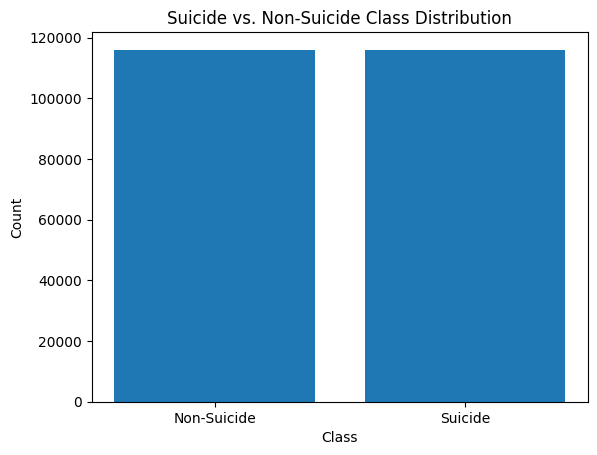

In [ ]:
# Count the number of suicide and non-suicide classes
suicide_count = data['class'].value_counts()[1]
non_suicide_count = data['class'].value_counts()[0]

# Create a bar plot
labels = ['Non-Suicide', 'Suicide']
values = [non_suicide_count, suicide_count]
plt.bar(labels, values)

# Add title and axis labels
plt.title('Suicide vs. Non-Suicide Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.show()

Data Preprocessing

In [3]:
data.drop(['Unnamed: 0'],axis=1,inplace=True) #This Column Not neccesary
data.head()
data['text'] = data['text'].str.lower()
# Remove leading and trailing whitespaces from the 'text' column
data['text'] = data['text'].str.strip()
print(data)

                                                     text        class
0       ex wife threatening suiciderecently i left my ...      suicide
1       am i weird i don't get affected by compliments...  non-suicide
2       finally 2020 is almost over... so i can never ...  non-suicide
3               i need helpjust help me im crying so hard      suicide
4       i’m so losthello, my name is adam (16) and i’v...      suicide
...                                                   ...          ...
232069  if you don't like rock then your not going to ...  non-suicide
232070  you how you can tell i have so many friends an...  non-suicide
232071  pee probably tastes like salty tea😏💦‼️ can som...  non-suicide
232072  the usual stuff you find herei'm not posting t...      suicide
232073  i still haven't beaten the first boss in hollo...  non-suicide

[232074 rows x 2 columns]


# Build Slang Dictionary

Replace all slang words with their proper English Words

In [4]:
file_path='/content/drive/MyDrive/Colab Notebooks/slang.txt'

with open(file_path,'r') as file:
  textfile_contents=file.read()
content_cleaned=textfile_contents.replace(',','')
slangs_dict={}
#print(content_cleaned)
for line in content_cleaned.splitlines():
  abbreviation, expanded_form = line.strip().split(':')
        # Store the abbreviation and its expanded form in the dictionary
  slangs_dict[abbreviation.strip()] = expanded_form.strip()


print(slangs_dict)

def replace_slang(text, slang_dict):
    for slang, expansion in slang_dict.items():
        text = text.replace(slang, expansion)
    return text
data['text'] = data['text'].apply(lambda x: replace_slang(x.lower(), slangs_dict))

print(data.head())

{'"awsm"': '"awesome"', '"aamof"': '"as a matter of fact"', '"abt"': '"about"', '"abt2"': '"about to"', '"ac"': '"air conditioning"', '"ace"': '"solo winner"', '"ack"': '"acknowledged"', '"admin"': '"administrator"', '"thr"': '"there"', '"frm"': '"from"', '"aggro"': '"aggression"', '"agl"': '"angel"', '"dob"': '"date of birth"', '"ai"': '"artificial intelligence"', '"aiic"': '"as if i care"', '"aka"': '"also known as"', '"alap"': '"as long as possible"', '"alol"': '"actually laughing out loud"', '"ama"': '"ask me anything"', '"amap"': '"as much as possible"', '"amazn"': '"amazing"', '"ammo"': '"ammunition"', '"ams"': '"ask me something"', '"anon"': '"anonymous"', '"asap"': '"as soon as possible"', '"asat"': '"as simple as that"', '"awks"': '"awkward"', '"awl"': '"always with love"', '"ayk"': '"as you know"', '"azm"': '"awesome"', '"b"': '"be"', '"b&w"': '"black and white"', '"b-day"': '"birthday"', '"bday"': '"birthday"', '"bcoz"': '"because"', '"bcos"': '"because"', '"bcz"': '"because

# Build Abreviation Dictionary
Replace all slang words with their proper English Words

In [6]:
file_path='/content/drive/MyDrive/Colab Notebooks/contractions1.0.txt'

contractions_dict = {}

with open(file_path, 'r') as file:
  lines = file.readlines()
  for line in lines:
    # Remove any whitespace and the trailing comma
    line = line.strip().rstrip(',')
    if line:
      # Split the line into contraction and expansion using regex to handle extra colons
      match = re.match(r'"([^"]+)":\s*"([^"]+)"', line)
      if match:
        contraction, expansion = match.groups()
                    # Add the contraction and its expansion to the dictionary
        contractions_dict[contraction] = expansion


print(contractions_dict)
def replace_contractions(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text
# Apply the replace_contractions function to the 'text' column
data['text'] = data['text'].apply(lambda x: replace_contractions(x, contractions_dict))

# Print the DataFrame
print(data)

{'ain’t': 'am not', 'aren’t': 'are not', 'can’t': 'cannot', 'can’t’ve': 'cannot have', '’cause': 'because', 'could’ve': 'could have', 'couldn’t': 'could not', 'couldn’t’ve': 'could not have', 'didn’t': 'did not', 'doesn’t': 'does not', 'don’t': 'do not', 'dont': 'do not', 'hadn’t': 'had not', 'hadn’t’ve': 'had not have', 'hasn’t': 'has not', 'haven’t': 'have not', 'he’d': 'he would', 'idk': 'i do not know', 'he’d’ve': 'he would have', 'he’ll': 'he will', 'he’ll’ve': 'he will have', 'he’s': 'he is', 'how’d': 'how did', 'how’d’y': 'how do you', 'how’ll': 'how will', 'how’s': 'how is', 'i’d': 'i would', 'i’d’ve': 'i would have', 'i’ll': 'i will', 'i’ll’ve': 'i will have', 'I’m': 'i am', 'Im': 'i am', 'i’m': 'i am', 'im': 'i am', 'I’ve': 'i have', 'ive': 'i have', 'Ive': 'i have', 'i’ve': 'i have', 'isn’t': 'is not', 'it’d': 'it had', 'it’d’ve': 'it would have', 'it’ll': 'it will', 'it’ll’ve': 'it will have', 'it’s': 'it is', 'let’s': 'let us', 'ma’am': 'madam', 'mayn’t': 'may not', 'might

Break up Double segmented words eg SuicideRecently

In [7]:
data['text'] = data['text'].apply(lambda text: " ".join(wordninja.split(text)))
print(data.head())

                                                text        class
0  ex wife threatening suicide recently i left my...      suicide
1  am i weird i do not get affected by comp li a ...  non-suicide
2  finally 2020 is almost over so i can never hea...  non-suicide
3       i need help just help me i am crying so hard      suicide
4  i am so lost hello my name is adam 16 and i ha...      suicide


Text Cleaning

In [8]:
def remove_html_tags(text):
  soup = BeautifulSoup(text,"html.parser") # remove Html tags
  return soup.get_text()

def remove_special_characters(text): # Get rid of special characters and punctation marks and digits
  pattern=r'[^a-zA-Z\s]'
  text=re.sub(pattern,'',text)
  return text

def output_to_Binary(label):
  if (label =="suicide"):  #  Convert the labels to Binary -1 positive and 0 being negative
    return 1
  else:
    return 0

def apply_datasetCleaning(text):
  text= remove_html_tags(text)
  text=remove_special_characters(text)
  return text

data['text']=data['text'].apply(apply_datasetCleaning)
data['class']=data['class'].apply(output_to_Binary)

print(data)

                                                     text  class
0       ex wife threatening suicide recently i left my...      1
1       am i weird i do not get affected by comp li a ...      0
2       finally  is almost over so i can never hear  h...      0
3            i need help just help me i am crying so hard      1
4       i am so lost hello my name is adam  and i have...      1
...                                                   ...    ...
232069  if you do not like rock then your not going to...      0
232070  you how you can tell i have so many friends an...      0
232071  pee probably tastes like salty tea can someone...      0
232072  the usual stuff you find here i am not posting...      1
232073  i still have not beaten the first boss in holl...      0

[232074 rows x 2 columns]


Further Text Cleaning

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
#Remove stop words
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text): #Lemmatiser
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
    #Lemmatise all the words for each text
data['text'] = data.text.apply(lemmatize_text)
print(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                     text  class
0       ex wife threatening suicide recently left wife...      1
1       weird get affected comp li ment coming someone...      0
2       finally almost never hear bad year ever swear ...      0
3                                need help help cry hard       1
4       lost hello name adam struggling year afraid pa...      1
...                                                   ...    ...
232069  like rock going get anything go http music tas...      0
232070  tell many friend lonely everything de pri pre ...      0
232071  pee probably taste like salty tea someone dran...      0
232072  usual stuff find posting sympathy pity know fa...      1
232073  still beaten first bos hollow knight fought ti...      0

[232074 rows x 2 columns]


In [10]:
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
nltk.download('words')
nltk.download('punkt')

# Load the set of English words
english_words = set(words.words())


# Function to remove non-English words from a list of tokens
def remove_non_english(tokens):
    english_tokens = [
        token if (token.lower() in english_words) else ''
        for token in tokens]
    return [token for token in english_tokens if token != '']

# Function to process text in the DataFrame
def process_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    clean_tokens = remove_non_english(tokens)  # Remove non-English words
    return ' '.join(clean_tokens)  # Reconstruct the text


# Apply the function to the 'text' column in the DataFrame
data['text'] = data['text'].apply(process_text)

print(data)


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                     text  class
0       ex wife threatening suicide recently left wife...      1
1       weird get affected li coming someone know feel...      0
2       finally almost never hear bad year ever swear ...      0
3                                 need help help cry hard      1
4       lost hello name struggling year afraid past ye...      1
...                                                   ...    ...
232069  like rock going get anything go music taste sp...      0
232070  tell many friend lonely everything de bought l...      0
232071  pee probably taste like salty tea someone dran...      0
232072  usual stuff find posting sympathy pity know fa...      1
232073  still beaten first hollow knight fought ti alw...      0

[232074 rows x 2 columns]


In [11]:
print(data['text'][0])
print(data['text'][3])
print(data['text'][4])
print(data['text'][20])

ex wife threatening suicide recently left wife good twice lied much decided refuse go back day ago threatening suicide tirelessly spent pa day talking keep hesitating want believe come back know lot people threaten order get way really supposed handle death hand still love wife can not deal getting constantly feeling insecure worried today may day hope much happen
need help help cry hard
lost hello name struggling year afraid past year thought suicide fear anxiety close li quiet long come family feeling year ago losing aunt triggered everyday feeling hopeless lost guilty remorseful thing done life thought like little experienced life ti revealed feeling family broke saw cut watching get worried something average day made feel absolutely dreadful later found attempt survivor attempt od overdose pill attempt hanging blackout pill never went noose still afraid first therapy severe depression social anxiety eating disorder later transferred en group therapy reason made feel anxious eventua

Visualisation of Data Balance

Splitting of Dataset

In [12]:
text=data['text'].values
labels=data['class'].values
print(labels)
train_texts, test_texts,train_labels,test_labels = train_test_split(text,labels, test_size=0.2,stratify=labels,
                                         random_state=7) # Splits Dataset into Training and Testing set
                                         #Startify ensures the proportion of the reginal dataset remains the same in the partioned sets
print("Train Data size:", len(train_texts))
print("Test Data size", len(test_texts))

[1 0 0 ... 0 1 0]
Train Data size: 185659
Test Data size 46415


Visualisation of Text Lengths

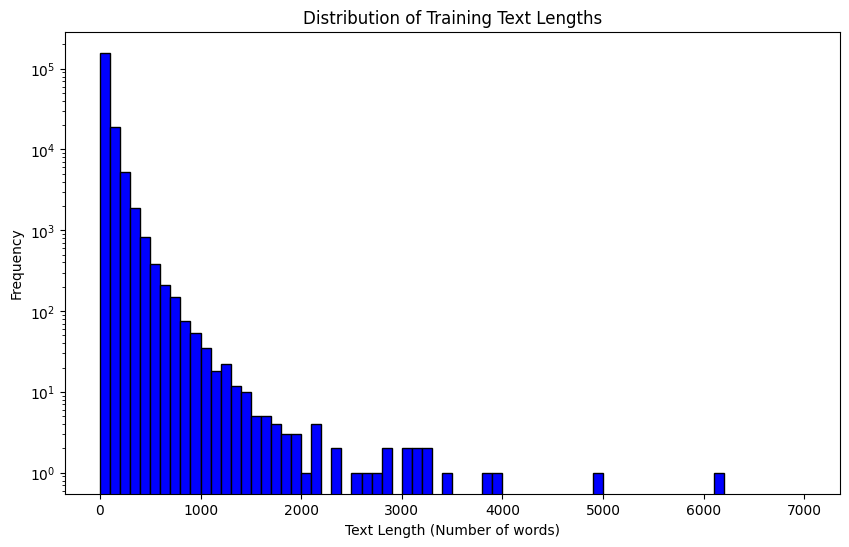

Mean training text length: 55.53702217506289
Median training text length: 26.0
Max training text length: 19445
Min training text length: 0


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the lengths of each training text
train_text_lengths = np.array([len(t.split()) for t in train_texts])

# Adjust the range and bins to include texts up to 7000 words
bins = np.arange(0, 7100, 100)  # Include up to 7000 words

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=bins, color='blue', edgecolor='black')
plt.title('Distribution of Training Text Lengths')
plt.xlabel('Text Length (Number of words)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for better visualization if needed
plt.show()

# Compute and print basic statistics
mean_length = np.mean(train_text_lengths)
median_length = np.median(train_text_lengths)
max_length = np.max(train_text_lengths)
min_length = np.min(train_text_lengths)

print(f"Mean training text length: {mean_length}")
print(f"Median training text length: {median_length}")
print(f"Max training text length: {max_length}")
print(f"Min training text length: {min_length}")


In [ ]:
# Calculate the proportion of texts below certain lengths
thresholds = [100,150,200,250,300,350,400,450,500 ,1000, 2000, 3000, 4000, 5000, 6000]
proportions = [(train_text_lengths < threshold).sum() / len(train_text_lengths) for threshold in thresholds]

# Print the proportions
for threshold, proportion in zip(thresholds, proportions):
    print(f"Proportion of texts with length below {threshold} words: {proportion:.4f}")

Proportion of texts with length below 100 words: 0.8488
Proportion of texts with length below 150 words: 0.9182
Proportion of texts with length below 200 words: 0.9517
Proportion of texts with length below 250 words: 0.9699
Proportion of texts with length below 300 words: 0.9799
Proportion of texts with length below 350 words: 0.9862
Proportion of texts with length below 400 words: 0.9900
Proportion of texts with length below 450 words: 0.9927
Proportion of texts with length below 500 words: 0.9945
Proportion of texts with length below 1000 words: 0.9992
Proportion of texts with length below 2000 words: 0.9999
Proportion of texts with length below 3000 words: 0.9999
Proportion of texts with length below 4000 words: 1.0000
Proportion of texts with length below 5000 words: 1.0000
Proportion of texts with length below 6000 words: 1.0000


Tokenising and padding text sequences to a fixed length for use in a neural network, converting words into numerical indices and ensuring all sequences are of the same length.

In [14]:


word_tokenizer = Tokenizer() #Tokenise text
word_tokenizer.fit_on_texts(train_texts) # assigns unique integer index to each word in dcitionary
train_texts = word_tokenizer.texts_to_sequences(train_texts) #converts sentences to their numeric form
test_texts = word_tokenizer.texts_to_sequences(test_texts)

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)
# Padding all texts to fixed length
avglen=int(sum(len(seq)for seq in train_texts)/len(train_texts))#Find longest text in training set
#
print(avglen) #
#average is train text has 64 words
train_texts = pad_sequences(train_texts, padding='post',maxlen=250)

test_texts = pad_sequences(test_texts, padding='post',maxlen=250)


23843
55


# Word Embeddings from GLOVE

In [15]:

# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
embedding_dim=100
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

#Create embedding matrix for all words in our vocab with embeddings from Glove
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(23843, 100)

# **Training**

Building LSTM

In [22]:
double_layer_lstm_model = Sequential([
    Embedding(input_dim=vocab_length,output_dim= embedding_dim,weights=[embedding_matrix],  input_length=250, trainable=False),#Feed pretrained embedding words
    LSTM(128, return_sequences=True), #  output the full sequence instead of the last output in the output sequence

    Dropout(0.5),# Dropout layer to prevent overfitting
    BatchNormalization(),# Batch normalization layer to normalize the inputs of the next layer

    # Lstm layers use default activation which is tanh
    LSTM(64, return_sequences=False),
    Dropout(0.5), # return_sequences=False: output the last output in the output sequence
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

double_layer_lstm_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

double_layer_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          2384300   
                                                                 
 lstm_4 (LSTM)               (None, 250, 128)          117248    
                                                                 
 dropout_5 (Dropout)         (None, 250, 128)          0         
                                                                 
 batch_normalization_5 (Bat  (None, 250, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                      

Training LSTM

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
callbacks = [
    # Stop training if validation loss dont improve for 3 consecutive epochs
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    # If model improves at the end of epoch, it is saved as best model
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_LSTMVFinal.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fit the model
history_2_0 = double_layer_lstm_model.fit(train_texts, train_labels, epochs=100, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
1160/1161 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.6841
Epoch 1: val_loss improved from inf to 0.33107, saving model to /content/drive/MyDrive/Colab Notebooks/best_LSTMVFinal.keras
1161/1161 [==============================] - 48s 37ms/step - loss: 0.5659 - accuracy: 0.6842 - val_loss: 0.3311 - val_accuracy: 0.8768
Epoch 2/100
1161/1161 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.8927
Epoch 2: val_loss improved from 0.33107 to 0.23980, saving model to /content/drive/MyDrive/Colab Notebooks/best_LSTMVFinal.keras
1161/1161 [==============================] - 40s 34ms/step - loss: 0.2804 - accuracy: 0.8927 - val_loss: 0.2398 - val_accuracy: 0.9093
Epoch 3/100
1161/1161 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9126
Epoch 3: val_loss improved from 0.23980 to 0.21761, saving model to /content/drive/MyDrive/Colab Notebooks/best_LSTMVFinal.keras
1161/1161 [==============================] - 40s 3

Building Bidirectional LSTM

In [26]:
double_bi_lstm_model = Sequential([
    #Embedding Layer
    Embedding(input_dim=vocab_length,output_dim= embedding_dim,weights=[embedding_matrix],  input_length=250, trainable=False),

    #1st Bidirectional LSTM Layer
    Bidirectional(LSTM(128, return_sequences=True)),#Default tanh activation function
    Dropout(0.2), # Prevent overfitting
    BatchNormalization(),

    #2nd Bi LSTM Layer
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])
  # compile model
double_bi_lstm_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


Training Bidirectional LSTM

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1,min_lr=0.0001),
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_modelDoubleBiLstmV7.2.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history3 = double_bi_lstm_model.fit(train_texts, train_labels,
                    batch_size=128,
                    epochs=100, verbose=1,
                    validation_split=0.2,callbacks=callbacks
                    )

Epoch 1/100
1160/1161 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.8887
Epoch 1: val_loss improved from inf to 0.23949, saving model to /content/drive/MyDrive/Colab Notebooks/best_modelDoubleBiLstmV7.2.keras
1161/1161 [==============================] - 85s 66ms/step - loss: 0.2783 - accuracy: 0.8887 - val_loss: 0.2395 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 2/100
1161/1161 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9156
Epoch 2: val_loss improved from 0.23949 to 0.20484, saving model to /content/drive/MyDrive/Colab Notebooks/best_modelDoubleBiLstmV7.2.keras
1161/1161 [==============================] - 81s 70ms/step - loss: 0.2194 - accuracy: 0.9156 - val_loss: 0.2048 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 3/100
1160/1161 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9235
Epoch 3: val_loss improved from 0.20484 to 0.19666, saving model to /content/drive/MyDrive/Colab Notebooks/best_modelDoubleBiLstmV7

Buiiding Concurrent Double Layer Bi LSTM

In [16]:


# Define the model
clstm_model = Sequential()

# Embedding layer
clstm_model.add(Embedding(input_dim=vocab_length,output_dim= embedding_dim,weights=[embedding_matrix], input_length=250, trainable=False))

# Convolutional layer
clstm_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
clstm_model.add(MaxPooling1D(pool_size=2))

clstm_model.add(Dropout(0.5))  #Can add batch normalisation
BatchNormalization(),
# First LSTM layer
clstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))

clstm_model.add(Dropout(0.2))
BatchNormalization(),
# Second LSTM layer
clstm_model.add(Bidirectional(LSTM(32)))

clstm_model.add(Dropout(0.2))  # Added dropout after the second LSTM layer
BatchNormalization(),
# Fully connected layers

clstm_model.add(Dense(1, activation='sigmoid'))  #

# Compile the model
clstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Summary of the model
clstm_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          2384300   
                                                                 
 conv1d (Conv1D)             (None, 248, 128)          38528     
                                                                 
 max_pooling1d (MaxPooling1  (None, 124, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 124, 128)          0         
                                                                 
 bidirectional (Bidirection  (None, 124, 256)          263168    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 124, 256)          0

Builidng Concurrent Double Layer Bi LSTM

In [17]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/bestCLSTM_modelVFinal.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fit the model
history_4 = clstm_model.fit(train_texts, train_labels, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
1161/1161 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8869
Epoch 1: val_loss improved from inf to 0.22727, saving model to /content/drive/MyDrive/Colab Notebooks/bestCLSTM_modelVFinal.keras
1161/1161 [==============================] - 59s 41ms/step - loss: 0.2821 - accuracy: 0.8869 - val_loss: 0.2273 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 2/50
1160/1161 [============================>.] - ETA: 0s - loss: 0.2287 - accuracy: 0.9122
Epoch 2: val_loss improved from 0.22727 to 0.21293, saving model to /content/drive/MyDrive/Colab Notebooks/bestCLSTM_modelVFinal.keras
1161/1161 [==============================] - 51s 44ms/step - loss: 0.2288 - accuracy: 0.9122 - val_loss: 0.2129 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 3/50
1161/1161 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9188
Epoch 3: val_loss improved from 0.21293 to 0.20374, saving model to /content/drive/MyDrive/Colab Notebooks/bestCLSTM_modelVFinal.keras
1161/1161

## **Evaluation**

Calculation of TP,TN,FP,FN

In [20]:
def perf_measure(y_actual, y_hat):
    global TP
    global FP
    global TN
    global FN
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

**Evaluation of LSTM**

1451/1451 [==============================] - 16s 9ms/step - loss: 0.1835 - accuracy: 0.9305
Test Accuracy: 93.05%
1451/1451 [==============================] - 12s 8ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     23207
           1       0.94      0.92      0.93     23208

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Double Layer LSTM Evaluation results : 

Accuracy - 0.93
Recall score - 0.92
Specificity - 0.94
Precision score - 0.94
f1_score - 0.93
False Positive Rate  - 0.06
False Negative Rate  - 0.08 




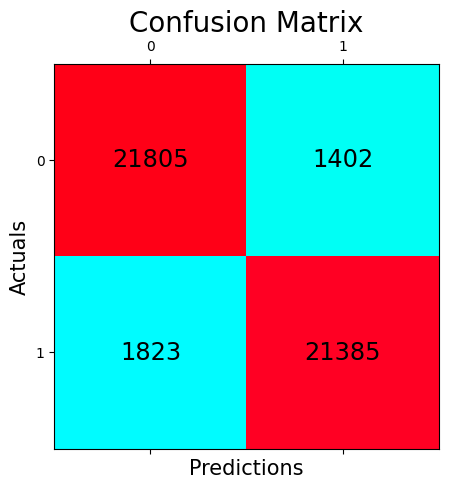

In [29]:
# Evaluation of LSTM
loaded_lstm_model=keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/best_LSTMVFinal.keras")
loss, accuracy = loaded_lstm_model.evaluate(test_texts, test_labels, verbose=1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions
predictions = loaded_lstm_model.predict(test_texts)
lstm_y_hat = (predictions > 0.5).astype("int32")  # For binary classification

# Display the results
from sklearn.metrics import classification_report
print(classification_report(test_labels, lstm_y_hat))
perf_measure(test_labels,lstm_y_hat)

lstm_conf_matrix = confusion_matrix(test_labels,lstm_y_hat)

# hsv_modified = cm.get_cmap('hsv', 256) //// old version
hsv_modified=colormaps.get_cmap('hsv')

color_lstm = ListedColormap(hsv_modified(np.linspace(0.5, 1, 256)))

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.matshow(lstm_conf_matrix, cmap=color_lstm, alpha=1)

for i in range(lstm_conf_matrix.shape[0]):
    for j in range(lstm_conf_matrix.shape[1]):
        ax1.text(x=j, y=i,s=lstm_conf_matrix[i, j], va='center', ha='center', size='xx-large')


print("Double Layer LSTM Evaluation results : \n")
print(f"Accuracy - {(accuracy_score(test_labels,lstm_y_hat)):.2f}")
print(f"Recall score - {(recall_score(test_labels,lstm_y_hat,pos_label=1)):.2f}")
print(f"Specificity - {(recall_score(test_labels,lstm_y_hat,pos_label=0)):.2f}")
print(f"Precision score - {(precision_score(test_labels,lstm_y_hat)):.2f}" )
print(f"f1_score - {(f1_score(test_labels,lstm_y_hat)):.2f}")
print(f"False Positive Rate  - {(FP / (FP+TN)):.2f}")
print(f"False Negative Rate  - {(FN / (TP+FN)):.2f} \n\n")

plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

**Evaluation of Bidirectional LSTM**

1451/1451 [==============================] - 25s 15ms/step - loss: 0.1742 - accuracy: 0.9354
Test Accuracy: 93.54%
1451/1451 [==============================] - 22s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     23207
           1       0.93      0.94      0.94     23208

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415

Logistic Regression Evaluation results : 

Accuracy - 0.94
Recall score - 0.94
Specificity - 0.93
Precision score - 0.93
f1_score - 0.94
False Positive Rate  - 0.07
False Negetive Rate  - 0.06 




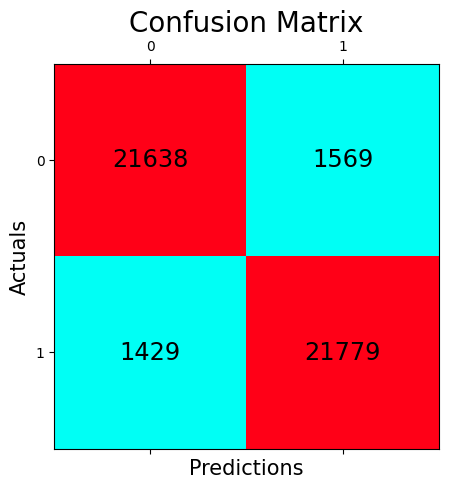

In [28]:
# EvaluaTION OF BiLstm
loaded_bi_lstm_model=keras.models.load_model("//content/drive/MyDrive/Colab Notebooks/best_modelDoubleBiLstmV7.2.keras")
loss, accuracy = loaded_bi_lstm_model.evaluate(test_texts, test_labels, verbose=1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predicti
predictions = loaded_bi_lstm_model.predict(test_texts)
bilstm_y_hat = (predictions > 0.5).astype("int32")  # For binary classification

# Display the results
from sklearn.metrics import classification_report
print(classification_report(test_labels, bilstm_y_hat))
perf_measure(test_labels,bilstm_y_hat)

bilstm_conf_matrix = confusion_matrix(test_labels,bilstm_y_hat)

# hsv_modified = cm.get_cmap('hsv', 256) //// old version
hsv_modified=colormaps.get_cmap('hsv')

color_bilstm = ListedColormap(hsv_modified(np.linspace(0.5, 1, 256)))

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.matshow(bilstm_conf_matrix, cmap=color_bilstm, alpha=1)

for i in range(bilstm_conf_matrix.shape[0]):
    for j in range(bilstm_conf_matrix.shape[1]):
        ax1.text(x=j, y=i,s=bilstm_conf_matrix[i, j], va='center', ha='center', size='xx-large')


print("Logistic Regression Evaluation results : \n")
print(f"Accuracy - {(accuracy_score(test_labels,bilstm_y_hat)):.2f}")
print(f"Recall score - {(recall_score(test_labels,bilstm_y_hat,pos_label=1)):.2f}")
print(f"Specificity - {(recall_score(test_labels,bilstm_y_hat,pos_label=0)):.2f}")
print(f"Precision score - {(precision_score(test_labels,bilstm_y_hat)):.2f}" )
print(f"f1_score - {(f1_score(test_labels,bilstm_y_hat)):.2f}")
print(f"False Positive Rate  - {(FP / (FP+TN)):.2f}")
print(f"False Negetive Rate  - {(FN / (TP+FN)):.2f} \n\n")

plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

**Evaluation of Concolutional Layered Bidirectional LSTM**

1451/1451 [==============================] - 16s 10ms/step - loss: 0.1819 - accuracy: 0.9312
Test Accuracy: 93.12%
1451/1451 [==============================] - 14s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     23207
           1       0.94      0.93      0.93     23208

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

Convolutional Layer Double Layer Bi LSTM Evaluation results : 

Accuracy - 0.93
Recall score - 0.93
Specificity - 0.94
Precision score - 0.94
f1_score - 0.93
False Positive Rate  - 0.06
False Negative Rate  - 0.07 




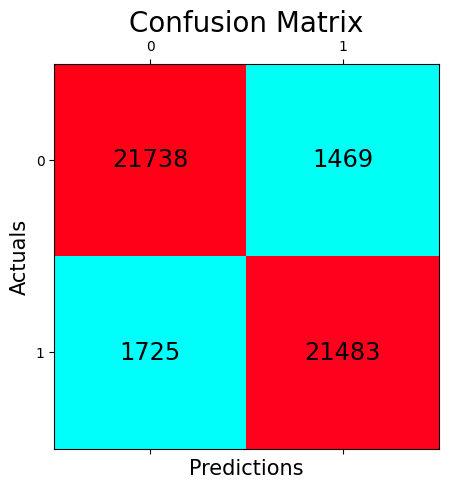

In [30]:
# Evaluation of CLSTM
loaded_clstm_model=keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/bestCLSTM_modelVFinal.keras")
loss, accuracy = loaded_clstm_model.evaluate(test_texts, test_labels, verbose=1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Make predictions
predictions = loaded_clstm_model.predict(test_texts)
clstm_y_hat = (predictions > 0.5).astype("int32")  # For binary classification

# Display the results
from sklearn.metrics import classification_report
print(classification_report(test_labels, clstm_y_hat))
perf_measure(test_labels,clstm_y_hat)

clstm_conf_matrix = confusion_matrix(test_labels,clstm_y_hat)

# hsv_modified = cm.get_cmap('hsv', 256) //// old version
hsv_modified=colormaps.get_cmap('hsv')

color_clstm = ListedColormap(hsv_modified(np.linspace(0.5, 1, 256)))

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.matshow(clstm_conf_matrix, cmap=color_clstm, alpha=1)

for i in range(clstm_conf_matrix.shape[0]):
    for j in range(clstm_conf_matrix.shape[1]):
        ax1.text(x=j, y=i,s=clstm_conf_matrix[i, j], va='center', ha='center', size='xx-large')


print("Convolutional Layer Double Layer Bi LSTM Evaluation results : \n")
print(f"Accuracy - {(accuracy_score(test_labels,clstm_y_hat)):.2f}")
print(f"Recall score - {(recall_score(test_labels,clstm_y_hat,pos_label=1)):.2f}")
print(f"Specificity - {(recall_score(test_labels,clstm_y_hat,pos_label=0)):.2f}")
print(f"Precision score - {(precision_score(test_labels,clstm_y_hat)):.2f}" )
print(f"f1_score - {(f1_score(test_labels,clstm_y_hat)):.2f}")
print(f"False Positive Rate  - {(FP / (FP+TN)):.2f}")
print(f"False Negative Rate  - {(FN / (TP+FN)):.2f} \n\n")

plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix', fontsize=20)
plt.show()